## TODO:
# Next notebook... (keep them short and sweet)
* Bring in custom dataset
* Try TinyVGG on custom dataset (conv layers etc) - https://poloclub.github.io/cnn-explainer/
* compare custom dataset on and off GPU
* Use TensorBoard integration in VSCode - can sync this up with Weights & Biases

In [3]:
import torch
from torch import nn

In [4]:
print(torch.__version__)

1.10.0


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Load data 

### Option 1 - Using `ImageFolder`

In [6]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [7]:
train_dir = "10_whole_foods/train"
test_dir = "10_whole_foods/test"

In [8]:
# Write transform for image
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])


    Image class: chicken_wings
    Original size: (551, 310)
    New size: torch.Size([64, 64, 3])
    


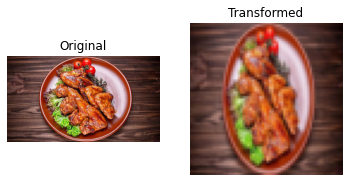

In [9]:
# Import image and transform
from PIL import Image
import random
import matplotlib.pyplot as plt
import pathlib
image_path_list = list(pathlib.Path("data/10_whole_foods/").glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
with Image.open(random_image_path) as f:
    plt.subplot(1, 2, 1)
    plt.imshow(f)
    plt.axis("off")
    plt.title("Original")
    plt.subplot(1, 2, 2)
    transformed_image = data_transform(f).permute(1, 2, 0) # change shape of image to suit matplotlib
    plt.imshow(transformed_image) 
    plt.title("Transformed")
    plt.axis("off")
    print(f"""
    Image class: {random_image_path.parent.stem}
    Original size: {f.size}
    New size: {transformed_image.shape}
    """)

In [10]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 654
     Root location: 10_whole_foods/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 164
     Root location: 10_whole_foods/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [11]:
class_names = train_data.classes
class_names

['apple',
 'banana',
 'beef',
 'blueberries',
 'carrots',
 'chicken_wings',
 'egg',
 'honey',
 'mushrooms',
 'strawberries']

Original shape: torch.Size([3, 64, 64])
Image permute shape: torch.Size([64, 64, 3])


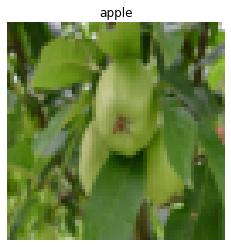

In [12]:
img, label = train_data[0][0], train_data[0][1]
img_permute = img.permute(1, 2, 0) # need to change shape for Matplotlib
print(f"Original shape: {img.shape}")
print(f"Image permute shape: {img_permute.shape}")
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label]);

In [13]:
img, label

(tensor([[[0.1922, 0.1686, 0.1176,  ..., 0.2078, 0.6706, 0.9961],
          [0.2235, 0.1490, 0.1059,  ..., 0.2392, 0.7961, 0.9882],
          [0.2392, 0.1490, 0.1098,  ..., 0.2275, 0.5804, 0.6588],
          ...,
          [0.4784, 0.2588, 0.2549,  ..., 0.1373, 0.1647, 0.2275],
          [0.4510, 0.2314, 0.3020,  ..., 0.1490, 0.1686, 0.2275],
          [0.3804, 0.2235, 0.2980,  ..., 0.1490, 0.1686, 0.2275]],
 
         [[0.1882, 0.2471, 0.2235,  ..., 0.3490, 0.7216, 0.9961],
          [0.2196, 0.2196, 0.2157,  ..., 0.3765, 0.8314, 0.9922],
          [0.2471, 0.2039, 0.2157,  ..., 0.3765, 0.6784, 0.7451],
          ...,
          [0.5882, 0.3608, 0.3529,  ..., 0.2706, 0.3098, 0.3804],
          [0.5529, 0.3333, 0.4078,  ..., 0.2824, 0.3098, 0.3765],
          [0.4824, 0.3255, 0.4118,  ..., 0.2824, 0.3098, 0.3804]],
 
         [[0.0431, 0.0706, 0.0353,  ..., 0.0353, 0.6235, 0.9961],
          [0.0627, 0.0275, 0.0157,  ..., 0.0745, 0.7765, 0.9922],
          [0.0745, 0.0235, 0.0078,  ...,

In [14]:
# Turn images into data loaders
train_dataloader = DataLoader(train_data, batch_size=1, num_workers=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, num_workers=1, shuffle=True)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fcb622699d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fcb62269ee0>)

In [15]:
img, label = next(iter(train_dataloader))
img.shape, label.shape # batch size is now 1 (try changing the batch_size parameter above)

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## Option 2: Custom data loader

We're going to recreate `torchvision.datasets.ImageFolder()` - https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder

* TK - why use this?
* TK - what's pros and cons? (e.g. more prone to errors but get full customization, have to write more code)

In [16]:
import pathlib
import random
import torch
import os

from PIL import Image
from torchvision import transforms
from typing import Tuple, Dict, List

In [17]:
# Make function to load images
def pil_loader(path: str) -> Image.Image:
    return Image.open(path) 

# Make function to find classes in target directory
# (assumes target directory is in standard image format)
def find_classes(directory: str) -> Tuple[List[str], Dict[str, str]]:
    """Finds the class folder names in a target directory.

    Args:
        directory ([str]): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, str]]: (list_of_class_names, dict(idx: class_name...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [18]:
find_classes(train_dir)

(['apple',
  'banana',
  'beef',
  'blueberries',
  'carrots',
  'chicken_wings',
  'egg',
  'honey',
  'mushrooms',
  'strawberries'],
 {'apple': 0,
  'banana': 1,
  'beef': 2,
  'blueberries': 3,
  'carrots': 4,
  'chicken_wings': 5,
  'egg': 6,
  'honey': 7,
  'mushrooms': 8,
  'strawberries': 9})

In [19]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset
class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir, transform=None):
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        self.transform = transform
        self.class_names, self.class_to_idx = find_classes(targ_dir)

    def __len__(self):
        return len(self.paths)

    
    def __getitem__(self, index):
        path = self.paths[index]
        class_name  = path.parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Open image
        img = pil_loader(path)

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label
        else:
            return img, class_idx

In [20]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_data_custom = ImageFolderCustom(train_dir, transform=train_transforms)
test_data_custom = ImageFolderCustom(test_dir, transform=test_transforms)
len(train_data_custom), len(test_data_custom)


(654, 164)

### TK - Create a function to display random images

In [21]:
def display_random_images(dataset, n=10, classes=None, seed=None):
  if n > 10:
    n = 10
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10.")

  if seed:
    random.seed(seed)  

  # Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # Setup plot
  plt.figure(figsize=(16, 8))

  # Loop through samples and display
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    # Min-max scale
    sample_min, sample_max = targ_image.min(), targ_image.max()
    sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

    # Adjust for shape (colour, height, width) -> (height, width, colour)
    sample_adjust = sample_scaled.permute(1, 2, 0)
    # print(sample_adjust)

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(sample_adjust)
    plt.axis("off")
    if classes:
      plt.title(classes[targ_label])

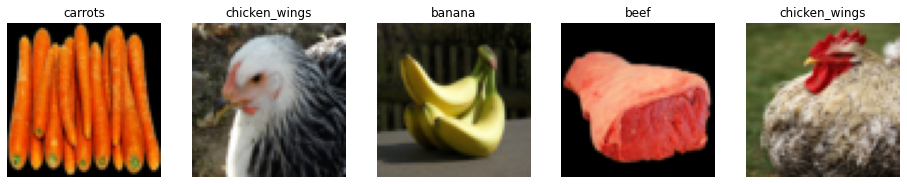

In [22]:
display_random_images(train_data, n=5, classes=class_names)

For display purposes, n shouldn't be larger than 10, setting to 10.


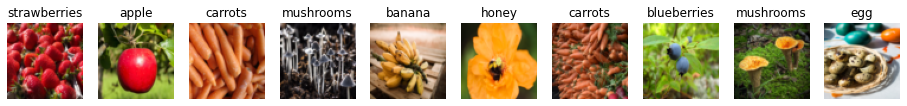

In [23]:
display_random_images(train_data_custom, n=12, classes=class_names)

In [24]:
# Turn image datasets into data loaders
train_dataloader_custom = DataLoader(train_data_custom, batch_size=1, num_workers=1, shuffle=True)
test_dataloader_custom = DataLoader(test_data_custom, batch_size=1, num_workers=1, shuffle=True)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fcb622699d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fcb62269ee0>)

In [25]:
img, label = next(iter(train_dataloader_custom))
img.shape, label.shape # batch size is now 1 (try changing the batch_size parameter above)

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## TK Other forms of Augmentation (transforms)

* RandAugment (random) - https://pytorch.org/vision/master/auto_examples/plot_transforms.html#randaugment
* TrivialAugment

In [27]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.RandAugment() # TODO: change to torch.uint8 tensor
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor()
])

TypeError: Only torch.uint8 image tensors are supported, but found torch.float32

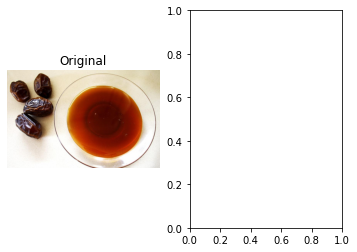

In [30]:
# Import image and transform
from PIL import Image
import random
import matplotlib.pyplot as plt
import pathlib
image_path_list = list(pathlib.Path("data/10_whole_foods/").glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
with Image.open(random_image_path) as f:
    plt.subplot(1, 2, 1)
    plt.imshow(f)
    plt.axis("off")
    plt.title("Original")
    plt.subplot(1, 2, 2)
    transformed_image = train_transforms(f).permute(1, 2, 0) # change shape of image to suit matplotlib
    plt.imshow(transformed_image) 
    plt.title("Transformed")
    plt.axis("off")
    print(f"""
    Image class: {random_image_path.parent.stem}
    Original size: {f.size}
    New size: {transformed_image.shape}
    """)

## TODO
* Finsh off transforms - RandAugment expects torch.uint8 as input - https://pytorch.org/vision/master/generated/torchvision.transforms.RandAugment.html#torchvision.transforms.RandAugment
* Build a model with and without data augmentation
* Build a model on a small subset of the data (e.g. 10 images per class)
* Build a model on a larger subset of the data (e.g. 100 images per class)
* Track results with PyTorch profiler
* Introduce transfer learning (beat the original model)

